In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as T
from torch.utils.data import WeightedRandomSampler, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os

sizes = ["224", "300", "512"]

device = "cuda" if torch.cuda.is_available() else "cpu"
classes = ["cheetah", "fox", "hyena", "lion", "tiger", "wolf"]

PATH = "~/Documents/datasets/wild_animals"

In [2]:
def norm_transforms(path, size):
    data_dir = path + "/" + size
    transforms = T.Compose(
        [T.Resize((int(size), int(size))), T.ToTensor()]
    )
    dataset = datasets.ImageFolder(root=data_dir, transform=transforms)

    imgs = {}
    for img_t, class_idx in dataset:
        if class_idx in imgs:
            imgs[class_idx].append(img_t)
        else:
            imgs[class_idx] = [img_t]

    norms, unnorms = {}, {}
    for i in range(len(imgs)):
        imgs[i] = torch.stack(imgs[i], dim=3)
        mean = np.array([m for m in imgs[i].view(3, -1).mean(dim=1)])
        std = np.array([s for s in imgs[i].view(3, -1).std(dim=1)])

        norms[i] = T.Normalize(
            mean = mean,
            std = std
        )
        unnorms[i] = T.Normalize(
            mean = -(mean/std),
            std = (1 / std)
        )
    
    return norms, unnorms

In [3]:
def load_data(path, size, norms):
    data_dir = path + "/" + size
    transform = T.Compose(
        [
            T.Resize((int(size), int(size))),
            T.ToTensor(),
        ]
    )
    dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    
    temp = []
    for (img_t, class_idx) in dataset:
        temp.append((norms[class_idx](img_t), class_idx))
    train_size = int(0.6 * len(dataset))
    test_size = len(dataset) - train_size

    dataset = temp

    train_data, test_data = torch.utils.data.random_split(
        dataset, [train_size, test_size]
    )

    return train_data, test_data

sample_size = sizes[-1]
norms, unnorms = norm_transforms(PATH, sample_size)
train_data, val_data = load_data(PATH, sample_size, norms)

/usr/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [5]:
test_img, class_idx = train_data[np.random.randint(0, len(train_data))]
imgs = [test_img.permute(1, 2, 0), unnorms[class_idx](test_img).permute(1, 2, 0)]

fig, axs = plt.subplots(1, 2, figsize=(20, 12))
axs[0].imshow(imgs[0])
axs[1].imshow(imgs[1])

NameError: name 'train_data' is not defined

In [5]:
def eval(model, data):
    with torch.no_grad():
        correct = 0

        for (img, label) in data:
            img_input = img.to(device).unsqueeze(0)
            pred = model(img_input)
            _, pred = torch.max(pred.squeeze(), 0)
            pred = pred.to("cpu")
            correct += pred.item() == label
        return correct, round((correct / len(data) * 100), 3)

def train(model, train_data, val_data, batch, epochs, lr):
    loader = DataLoader(
        train_data,
        batch_size=batch,
        shuffle=True,
        num_workers=2,
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0.0001, momentum=0.9)

    epoch_data = []
    for epoch in range(epochs):
        running_loss, running_acc = 0., 0.
        for i, (imgs, labels) in enumerate(loader):
            inputs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, pred = torch.max(outputs, dim=1)
            running_acc += torch.sum(pred == labels).item()

        model.eval()
        _, val_acc = eval(model, val_data)
        model.train()

        running_acc = round(running_acc / len(train_data) * 100, 3)
        running_loss /= len(loader)
        print(f'epoch: {epoch + 1} loss: {running_loss:.6f}')
        epoch_data.append(
            (epoch, float(f"{(running_loss):.6f}"), running_acc, val_acc)
        )
    
    return epoch_data

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, k_size, stride, pad):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, k_size, stride, pad)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)

        return x

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down_sample, stride):
        super(ResBlock, self).__init__()
        self.layers = nn.Sequential(
            ConvBlock(in_channels, out_channels, 1, 1, 0),
            ConvBlock(out_channels, out_channels, 3, stride, 1),
            ConvBlock(out_channels, out_channels * 4, 1, 1, 0),
        )
        self.relu = nn.ReLU()
        self.down_sample = down_sample

    def forward(self, x):
        identity = x.clone()
        x = self.layers(x)
        if self.down_sample:
            identity = self.down_sample(identity)
        x += identity
        x = self.relu(x)

        return x

class ResNet152(nn.Module):
    def __init__(self, n_classes, depth):
        super(ResNet152, self).__init__()
        self.in_channels = 64
        self.out_channels = 64

        self.conv1 = ConvBlock(depth, self.out_channels, 7, 2, 3)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(3, 2, 1)

        self.conv2_x = self._gen_layer(3, self.out_channels, 1)
        self.out_channels *= 2
        self.conv3_x = self._gen_layer(8, self.out_channels, 2)
        self.out_channels *= 2
        self.conv4_x = self._gen_layer(36, self.out_channels, 2)
        self.out_channels *= 2
        self.conv5_x = self._gen_layer(3, self.out_channels, 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.layers = nn.Sequential(
            self.conv1,
            self.relu,
            self.max_pool,
            self.conv2_x,
            self.conv3_x,
            self.conv4_x,
            self.conv5_x,
            self.avg_pool
        )
        self.fcl = nn.Linear(2048, n_classes)

    def _gen_layer(self, n_res_blocks, out_channels, stride):
        layers = []
        down_sample = ConvBlock(self.in_channels, out_channels * 4, 1, stride, 0)

        layers.append(
            ResBlock(self.in_channels, out_channels, down_sample, stride)
        )
        self.in_channels = out_channels * 4

        for _ in range(n_res_blocks - 1):
            layers.append(ResBlock(self.in_channels, out_channels, None, 1))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        x = x.flatten(1)
        x = self.fcl(x)

        return x


In [7]:
def run():
    lr = 0.01
    num_layers = 4
    batch_size = 32
    num_epochs = 75
    runs = []

    for size in sizes:
        model = ResNet152(len(classes), 3).to(device)
        train_data, val_data = load_data(PATH, size, norms)
        epoch_data = train(
            model,
            train_data,
            val_data,
            batch_size,
            num_epochs,
            lr
        )
        runs.append(epoch_data)
        del model
        break

    return runs

epoch_data = run()

epoch: 1 loss: 3.589176
epoch: 2 loss: 2.503372
epoch: 3 loss: 2.186131
epoch: 4 loss: 1.944308
epoch: 5 loss: 1.804949
epoch: 6 loss: 1.826571
epoch: 7 loss: 1.860024
epoch: 8 loss: 1.783342
epoch: 9 loss: 1.728884
epoch: 10 loss: 1.717530
epoch: 11 loss: 1.751983
epoch: 12 loss: 1.711615
epoch: 13 loss: 1.628684
epoch: 14 loss: 1.465777
epoch: 15 loss: 1.397960
epoch: 16 loss: 1.344070
epoch: 17 loss: 1.325426
epoch: 18 loss: 1.335211
epoch: 19 loss: 1.277650
epoch: 20 loss: 1.308876
epoch: 21 loss: 1.247492
epoch: 22 loss: 1.194219
epoch: 23 loss: 1.188456
epoch: 24 loss: 1.162957
epoch: 25 loss: 1.169436
epoch: 26 loss: 1.166706
epoch: 27 loss: 1.140183
epoch: 28 loss: 1.082090
epoch: 29 loss: 1.062033
epoch: 30 loss: 1.078071
epoch: 31 loss: 1.051388
epoch: 32 loss: 1.075350
epoch: 33 loss: 0.932287
epoch: 34 loss: 0.979341
epoch: 35 loss: 1.006521
epoch: 36 loss: 0.997548
epoch: 37 loss: 0.949287
epoch: 38 loss: 0.885942
epoch: 39 loss: 0.919519
epoch: 40 loss: 0.865582
epoch: 41

ResNet accuracy: 0.899


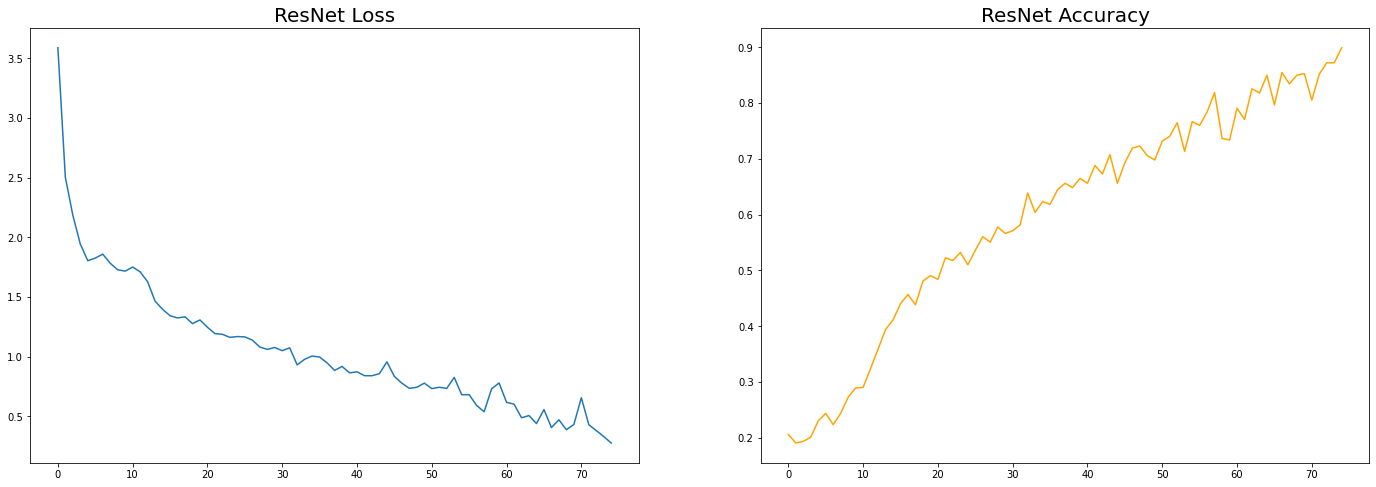

In [8]:
train_info = [*zip(*epoch_data[0])]
acc = np.array(train_info[2]) / 100

fig, axs = plt.subplots(1, 2, figsize=(24, 8))
axs[0].set_title("ResNet Loss", fontsize=20)
axs[1].set_title("ResNet Accuracy", fontsize=20)
axs[0].plot(train_info[0], train_info[1])
axs[1].plot(train_info[0], acc, color="orange")

print(f"ResNet accuracy: {acc[-1]:.3f}")